In [ ]:
# default_exp cluster

# 2. Cluster Analysis

Households are to be clustered based on either hourly or daily consumption profiles.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from elec_consumption.core import *
import elec_consumption.performance as performance
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
from sklearn import metrics
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.utils import (
    check_equal_size, to_time_series_dataset, to_sklearn_dataset
)

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [4 * 1.61803398875, 4]
_seed = 123  # for clustering analysis

Import dataframe and test.

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

In [ ]:
#hide
mts = to_time_series_dataset(df.fillna(0).T)
n_ts, max_sz, d = mts.shape

In [ ]:
assert (n_ts == 500 and max_sz == 5856 and d == 1)
assert check_equal_size(mts)

## 1. Example
For example, assume there are 4 clusters.

In [ ]:
#hide
km = TimeSeriesKMeans(
    n_clusters=4, verbose=False, random_state=_seed)
clustered = km.fit_predict(mts)

description = df.describe().T
description['cluster_id'] = clustered

In [ ]:
#hide_input
description.head(3)

,count,mean,std,min,25%,50%,75%,max,cluster_id
household,,,,,,,,,
0,5328.0,0.122169,0.135841,0.011,0.052,0.082,0.137,1.540,1
1,5280.0,0.128278,0.154372,0.010,0.043,0.075,0.144,1.479,1
2,5328.0,0.147232,0.093699,0.026,0.086,0.126,0.180,1.131,1


Sum of distances of samples to their closest cluster center:

## 2. Performance Evaluation

In [ ]:
#hide
mts_sklearn = to_sklearn_dataset(mts)

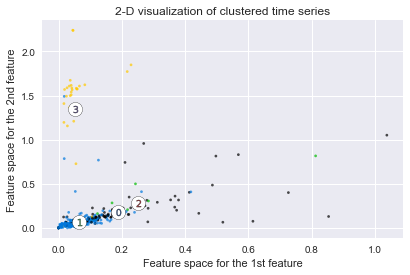

In [ ]:
#hide_input
performance.plot_silhouette_2d(
    4, clustered, mts_sklearn, centers=km.cluster_centers_
)

For n_clusters = 4 The average silhouette_score is : 0.27821213695582137


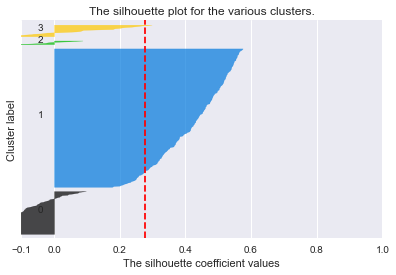

In [ ]:
#hide_input
performance.plot_silhouette(
    4, clustered, mts_sklearn
)

## 3. Use `KShape`

It takes a while to cluster using `KShape`.

In [ ]:
#hide
# ks = KShape(3, verbose=False)
# clustered_ks = ks.fit_predict(mts)
# description['cluster_id_ks'] = clustered_ks

### Optimal Num of Clusters

In [ ]:
#export
def cal_inertia(n_clusters: int) -> float:
    """Calculate sum of distances to closest cluster centre.
    
    Args:
        n_clusters: number of clusters.
    
    Returns:
        Sum of distances to closest cluster centre.
    """
    km = TimeSeriesKMeans(
        n_clusters=n_clusters, verbose=False, random_state=_seed)
    km.fit_predict(mts)
    return km.inertia_

In [ ]:
#hide
y = []
x = [i for i in range(1, 15)]
for n_clusters in x:
    y.append(cal_inertia(n_clusters))

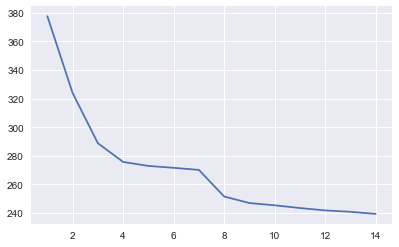

In [ ]:
#hide_input
sns.lineplot(x=x, y=y);